# Lab2: Adversarial Attacks on Deep Neural Networks

## Load Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10, cifar100
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#loading the MNIST 
fashion_mnist = tf.keras.datasets.fashion_mnist
(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

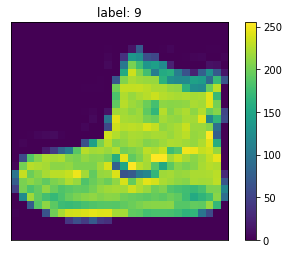

In [3]:
# Plot picture
i=0
fig, ax = plt.subplots(1,1)
im=ax.imshow(xTrain[i])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('label: {}'.format(yTrain[i]))
fig.colorbar(im)
plt.grid(False)
plt.show()

In [4]:
xTrain[0].shape

(28, 28)

In [5]:
# Preprocessing
img_rows, img_cols = xTrain[0].shape
numOfClasses = 10

xTrain = xTrain
xTest = xTest

# we also need to scale between 0 and 1:
xTrain = xTrain / 255.0
xTest = xTest / 255.0

## Baseline DNN

**Q1**: Implement baseline DNN

The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations.

In [6]:
baseModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10)
])
baseModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
baseModel.fit(xTrain, yTrain, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4807 - accuracy: 0.8308
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3617 - accuracy: 0.8683
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3251 - accuracy: 0.8812
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3020 - accuracy: 0.8893
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2843 - accuracy: 0.8938
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2677 - accuracy: 0.8995
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2560 - accuracy: 0.9047
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2456 - accuracy: 0.9072
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2325 - accuracy: 0.9127
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.226

In [7]:
print("Base loss and accuracy on regular images:", baseModel.evaluate(x=xTest, y=yTest, verbose=0))

Base loss and accuracy on regular images: [0.3295533061027527, 0.8844000101089478]


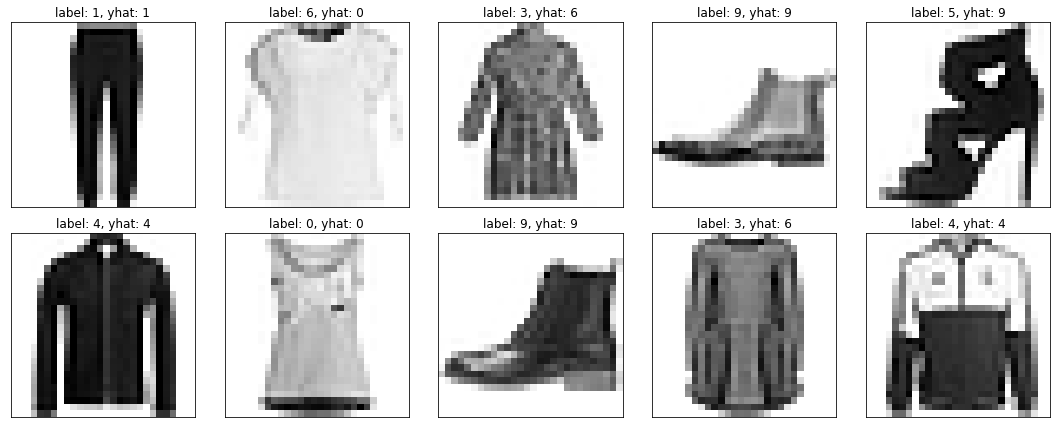

In [8]:
# predict test set images labels
yhat = np.argmax(baseModel.predict(xTest),axis=1)

#plot some images from the test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(xTest[randIdx[i]], cmap=plt.cm.binary)
    ax.set_title('label: {}, yhat: {}'.format(yTest[randIdx[i]],yhat[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## FGSM based untargeted attacks

**Q2**: Implement FGS untargetd attack

# FGSM based untargeted attacks

Assume the network assigns an image $x$ with the lable $y$, 

$y = \text{classifier}(x)$. 

For an untargeted attacks the adversary is seeking to produce an image $x'$ which is different from $x$ such that applying $\text{classifier}(x')$ to this image we obtain a label $y'$ which is different from the original label $y$, i.e. $y'=\text{classifier}(x')\neq y$. The modification to image $x$ should be imperceptable, i.e. less than some constrain $\delta$:

$\|x-x'\|<\delta$.

The larger the $\delta$ the more noticeable the modification is, but attackers's objective is achieved more easily, and vice versa -- smaller $\delta$ assumes less tolerance to the modification.

Fast Gradient Sign Method allows the attacker to modify an image by taking a single step in the loss function gradient direction (for non-targeted attacks), taking into account the sign of the gradient:

$x' \leftarrow \text{clip}\left(x+\epsilon\text{sign}\left(\nabla l_{F,y^*}(x)\right)\right)$

where $\epsilon$ is a small constraint value,$l$ is the lost function and $\text{clip}()$ function brings all the pixels of the image to the same range, e.g. from 0 to 255.

The attackers goal is to increase the value of $l_{F,y^*}(x)$, where $x$ image, $F$--network and $y^*= F(x)$ -- the ground-truth label, i.e. the attacker is interested to producing any label $y'$ which is different of $y^*$. This is achieved by increasing the loss $l_{F,y^*}(x)$. He computes the sign of the gradient of loss functoin and makes a step along the gradient direction. The "length" of the step is controlled by $\epsilon$.

We will be applying the FGSM based untargeted attack using images from the test set on the baseline DNN. 

In [9]:
def FGS_untargeted_attack(X, label, model, loss_func, eps=1):
    newX = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    #tf.GradientTape allows us to track TensorFlow computations and calculate gradients w.r.t. some given variables
    #https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22
    #https://www.tensorflow.org/api_docs/python/tf/GradientTape?hl=hu
    with tf.GradientTape() as g:
        g.watch(X_tensor)
        lossTensor = loss_func(label, model(X_tensor))

    # calculate gradients of loss function:
    lossGradientsTensor = g.gradient(lossTensor, X_tensor)
    
    for i in range(X.shape[0]):
        newX[i,:,:] = np.clip(X[i]+eps*np.sign(lossGradientsTensor[i,:,:]), 0.0, 1.0) 
        
    return newX

## Visualize the modified images

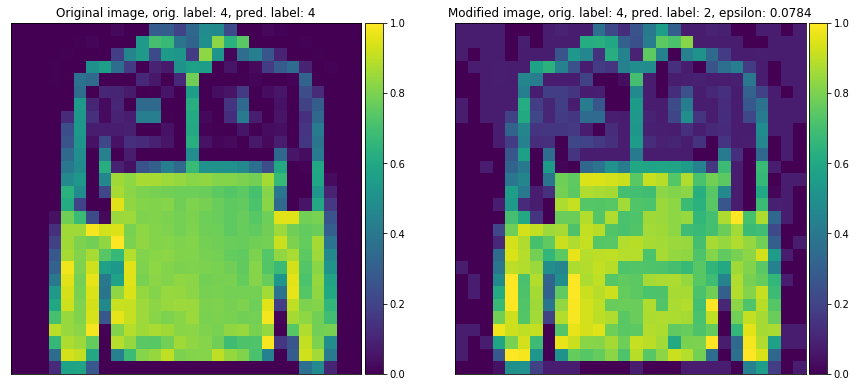

In [10]:
e = 20/255
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
xTestAftAttack = FGS_untargeted_attack(xTest, yTest, baseModel, loss_func, eps=e)

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)

# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)

# plot randomly selected modified and original images side-by-side
from mpl_toolkits.axes_grid1 import make_axes_locatable

num = 10
# set some specific seed
np.random.seed(45)
# define the random index of the image which we will be using all the time here
randIdx = [np.random.randint(10000) for i in range(num)]
idx = -1

fig, axes = plt.subplots(1, 2, figsize=(12,12))
divider1 = make_axes_locatable(axes[0])
divider2 = make_axes_locatable(axes[1])
im1  =  axes[0].imshow(xTest[randIdx[idx]])
im2  =  axes[1].imshow(xTestAftAttack[randIdx[idx]])
axes[0].set_title('Original image, orig. label: {}, pred. label: {}'.format(yTest[randIdx[idx]], yhat[randIdx[idx]]))
axes[1].set_title('Modified image, orig. label: {}, pred. label: {}, epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrime[randIdx[idx]], e))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
im1.set_clim(0, 1)
im2.set_clim(0, 1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
plt.tight_layout()
plt.show()


**Q3**: Calculate the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$, and plot the result.

In [11]:
epss = np.asarray([1, 5, 10, 20, 30, 40, 50])/255.0
rptUntargeted = pd.DataFrame(index=epss, columns=['Confuse_frac'])


# we also want to compare the modified images visually, let's take the last image from test set for comparison
idx=-1
num = 10
# let the first image be original
modifiedImagesArrayUntargeted = [xTest[randIdx[idx]]]
yhatPrimeArray = [yTest[randIdx[idx]]]
# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
    
for e in epss:
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    xTestAftAttack = FGS_untargeted_attack(xTest, yTest, baseModel, loss_func, eps=e)
    
    modifiedImagesArrayUntargeted.append(xTestAftAttack[randIdx[idx]])
    
    # labels after classifying modified images
    yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
    
    # to monitor whether the label was misidentified
    yhatPrimeArray.append(yhatPrime[randIdx[idx]])
    
    #the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
    #that are mis-classified after adversarial perturbation

    # indices of images correctly classified by the baseline DNN
    correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

    # number of images correctly classified by the baseline DNN
    numCorrectlyClassified = np.sum(yhat==yTest)

    # number of images mis-classified after adversarial perturbation
    numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

    #success rate of attack:
    attackSR = numMisclassified/numCorrectlyClassified
    print("The success rate of untargeted attack with epsilon {:.4f} is {:.4f}".format( e, attackSR))

    rptUntargeted.loc[e, 'Confuse_frac'] = attackSR
    rptUntargeted.loc[e, 'Baseline_accuracy_untargeted'] = np.sum(yhatPrime==yTest)/yTest.shape
rptUntargeted

The success rate of untargeted attack with epsilon 0.0039 is 0.0341
The success rate of untargeted attack with epsilon 0.0196 is 0.2152
The success rate of untargeted attack with epsilon 0.0392 is 0.4778
The success rate of untargeted attack with epsilon 0.0784 is 0.7792
The success rate of untargeted attack with epsilon 0.1176 is 0.8894
The success rate of untargeted attack with epsilon 0.1569 is 0.9400
The success rate of untargeted attack with epsilon 0.1961 is 0.9631


,Confuse_frac,Baseline_accuracy_untargeted
0.003922,0.0341474,0.8542
0.019608,0.215174,0.6941
0.039216,0.477838,0.4618
0.078431,0.779172,0.1953
0.117647,0.889417,0.0978
0.156863,0.939959,0.0531
0.196078,0.963139,0.0326


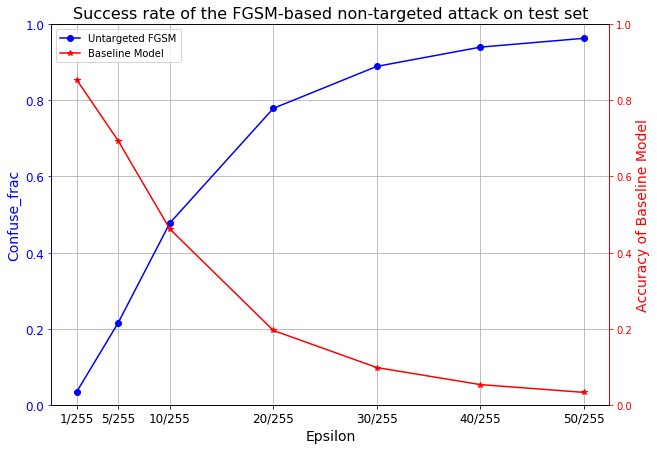

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
ax2 = ax.twinx()
plt.title("Success rate of the FGSM-based non-targeted attack on test set",fontsize="16")
ax.set_xticks(epss)
ax.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="12")
ax.set_xlabel('Epsilon', fontsize="14")
ax.set_ylabel('Confuse_frac', fontsize="14")
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue', labelsize=12)
ax.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax.set_xlabel('Epsilon', fontsize="14")
ax.plot(epss, rptUntargeted['Confuse_frac'], 'bo-',label = "Untargeted FGSM")
ax.plot(epss, rptUntargeted['Baseline_accuracy_untargeted'], 'r*-',label = "Baseline Model")
ax.set_ylim([0,1])
ax.grid()
ax.legend();


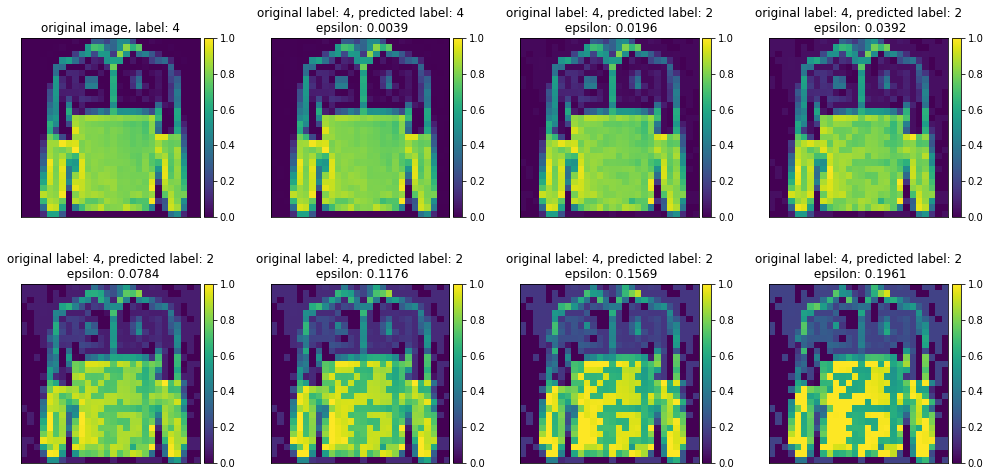

In [13]:
# plot modified versions of one image from test set to compare
num = 8
num_row = 2
num_col = 4
idx = -1 
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3.5*num_col,3.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    im = ax.imshow(modifiedImagesArrayUntargeted[i])
    if i==0:
        ax.set_title('original image, label: {}'.format(yTest[randIdx[idx]]))
    else:
        ax.set_title('original label: {}, predicted label: {}\n epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrimeArray[i], epss[i-1]))
    ax.set_xticks([])
    ax.set_yticks([])
    divider= make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im.set_clim(0, 1)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

## FGSM based targeted attacks

**Q4**: Implement FGS targetd attack


Fast Gradient Sign Method allows the attacker to modify an image by taking a single step in the loss function gradient direction (for targeted attacks), taking into account the sign of the gradient:

$x' \leftarrow \text{clip}\left(x-\epsilon\text{sign}\left(\nabla l_{F,y'}(x)\right)\right)$

where $\epsilon$ is a small constraint value,$l$ is the lost function and $\text{clip}()$ function brings all the pixels of the image to the same range, e.g. from 0 to 255.

The attacker's goal is to increase the value of $l_{F,y'}(x)$, where $x$ image, $F$--network and $y'$ -- the label specified by the attacker, which is different of groung-truth label $y^*$. This is achieved by decreasing the loss $l_{F,y'}(x)$. He computes the sign of the gradient of loss function and makes a step opposite the gradient direction. The "length" of the step is controlled by $\epsilon$.

We will be applying the FGSM based targeted attack using images from the test set on the baseline DNN. 



In [14]:
def FGS_targeted_attack(X, label, model, loss_func, eps=1):
    newX = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    
    # targets set by attacker
    targetLabel = [(y+1)%10 for y in label]

    with tf.GradientTape() as g:
        g.watch(X_tensor)
        lossTensor = loss_func(targetLabel, model(X_tensor))

    # calculate gradients of loss function:
    lossGradientsTensor = g.gradient(lossTensor, X_tensor)
    
    for i in range(X.shape[0]):
        newX[i] = np.clip(X[i]-eps*np.sign(lossGradientsTensor[i]), 0.0, 1.0) 
        
    return newX

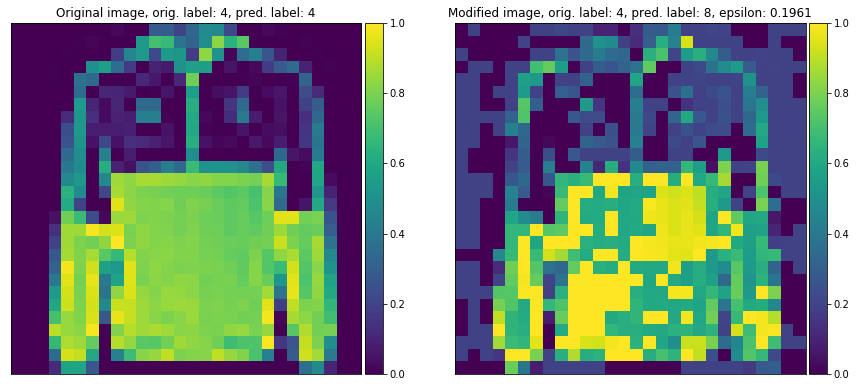

In [15]:
e = 50/255
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
xTestAftAttack = FGS_targeted_attack(xTest, yTest, baseModel, loss_func, eps=e)

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
# target labels
targetLabels = [(y+1)%10 for y in yTest]
# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)

# plot randomly selected modified and original images side-by-side
from mpl_toolkits.axes_grid1 import make_axes_locatable
idx = -1
num = 10

fig, axes = plt.subplots(1, 2, figsize=(12,12))
divider1 = make_axes_locatable(axes[0])
divider2 = make_axes_locatable(axes[1])
im1  =  axes[0].imshow(xTest[randIdx[idx]])
im2  =  axes[1].imshow(xTestAftAttack[randIdx[idx]])
axes[0].set_title('Original image, orig. label: {}, pred. label: {}'.format(yTest[randIdx[idx]], yhat[randIdx[idx]]))
axes[1].set_title('Modified image, orig. label: {}, pred. label: {}, epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrime[randIdx[idx]], e))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
im1.set_clim(0, 1)
im2.set_clim(0, 1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
plt.tight_layout()
plt.show()


**Q5**:Report the attack’s success rate as a function of parameter $\epsilon$ where success rate is defined as the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label (i+1)%10.

In [16]:
epss = np.asarray([1, 5, 10, 20, 30, 40, 50])/255.0
rptTargeted = pd.DataFrame(index=epss, columns=['Mislead_frac'])

# we also want to compare the modified images visually, let's take the last image from test set for comparison
idx=-1
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
# let the first image be original
modifiedImagesArrayTargeted = [xTest[randIdx[idx]]]
yhatPrimeArray = [yTest[randIdx[idx]]]

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
    
# target labels
targetLabels = np.asarray([(y+1)%10 for y in yTest])
    
for e in epss:
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    xTestAftAttack = FGS_targeted_attack(xTest, yTest, baseModel, loss_func, eps=e)
    
    modifiedImagesArrayTargeted.append(xTestAftAttack[randIdx[idx]])
    
    # labels after classifying modified images
    yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
    
    # to monitor whether the label was misidentified
    yhatPrimeArray.append(yhatPrime[randIdx[idx]])
    
    #the success rate of attack is the fraction of those test images that were correctly classified by the baseline DNN 
    #that became mis-classified after adversarial perturbations with label (i+1)%10    
    
    # number of images correctly classified by the baseline DNN
    correctlyClassifiedIdx = yhat==yTest
    numCorrectlyClassified = np.sum(correctlyClassifiedIdx)
    
    # number of images correctly classified by baseline model that became mis-classified after adversarial perturbations with label (i+1)%10
    misClassifiedTargetIdx = yhatPrime[correctlyClassifiedIdx] == targetLabels[correctlyClassifiedIdx]
    numMisclassifiedTarget = np.sum(misClassifiedTargetIdx)
    
     
    #success rate of attack:
    attackSR = numMisclassifiedTarget/numCorrectlyClassified
    print("The success rate of targeted attack with epsilon {:.4f} is {:.4f}".format( e, attackSR))

    rptTargeted.loc[e, 'Mislead_frac'] = attackSR
    rptTargeted.loc[e, 'Baseline_accuracy_targeted'] = np.sum(yhatPrime==yTest)/yTest.shape
rptTargeted

The success rate of targeted attack with epsilon 0.0039 is 0.0006
The success rate of targeted attack with epsilon 0.0196 is 0.0126
The success rate of targeted attack with epsilon 0.0392 is 0.0735
The success rate of targeted attack with epsilon 0.0784 is 0.2697
The success rate of targeted attack with epsilon 0.1176 is 0.4054
The success rate of targeted attack with epsilon 0.1569 is 0.4758
The success rate of targeted attack with epsilon 0.1961 is 0.4964


,Mislead_frac,Baseline_accuracy_targeted
0.003922,0.000565355,0.8843
0.019608,0.0125509,0.8632
0.039216,0.0734962,0.7569
0.078431,0.269674,0.4288
0.117647,0.40536,0.1851
0.156863,0.475803,0.0616
0.196078,0.496382,0.0217


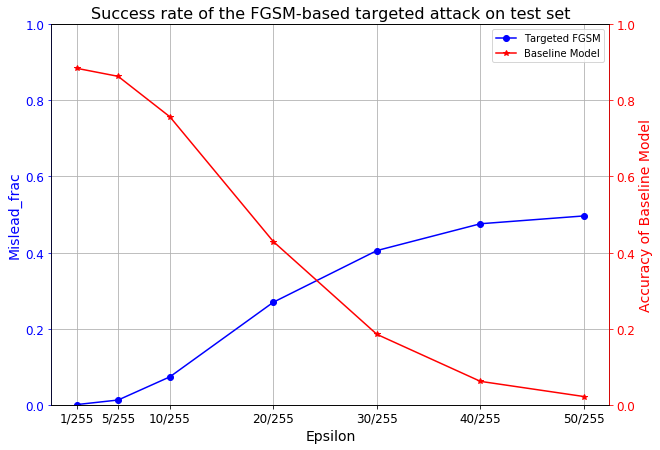

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
ax2 = ax.twinx()
plt.title("Success rate of the FGSM-based targeted attack on test set",fontsize="16")
ax.set_xticks(epss)
ax.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="12")
ax.set_xlabel('Epsilon', fontsize="14")
ax.set_ylabel('Mislead_frac', fontsize="14")
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue', labelsize=12)
ax.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red', labelsize=12)
ax2.yaxis.label.set_color('red')
ax.plot(epss,  rptTargeted['Mislead_frac'], 'bo-',label = "Targeted FGSM")
ax.plot(epss, rptTargeted['Baseline_accuracy_targeted'], 'r*-',label = "Baseline Model")
ax.set_ylim([0,1])
ax.grid()
ax.legend();

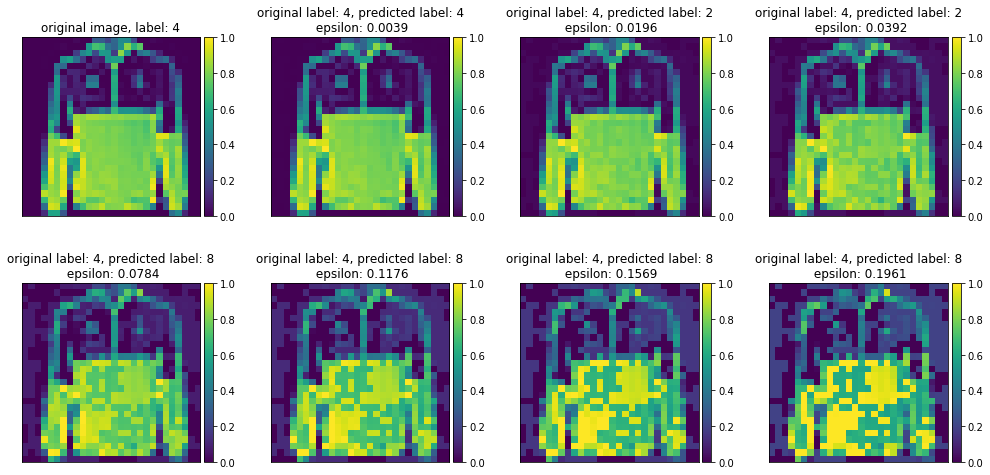

In [18]:
# plot modified versions of one image from test set to compare
num = 8
num_row = 2
num_col = 4
idx = -1 
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3.5*num_col,3.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    im = ax.imshow(modifiedImagesArrayTargeted[i])
    if i==0:
        ax.set_title('original image, label: {}'.format(yTest[randIdx[idx]]))
    else:
        ax.set_title('original label: {}, predicted label: {}\n epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrimeArray[i], epss[i-1]))
    ax.set_xticks([])
    ax.set_yticks([])
    divider= make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im.set_clim(0, 1)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

For this particular image we can notice that the targeted attack happens starting from $\epsilon = \frac{40}{255}$ when the image is classified with the label (i+1)%10 = 5.

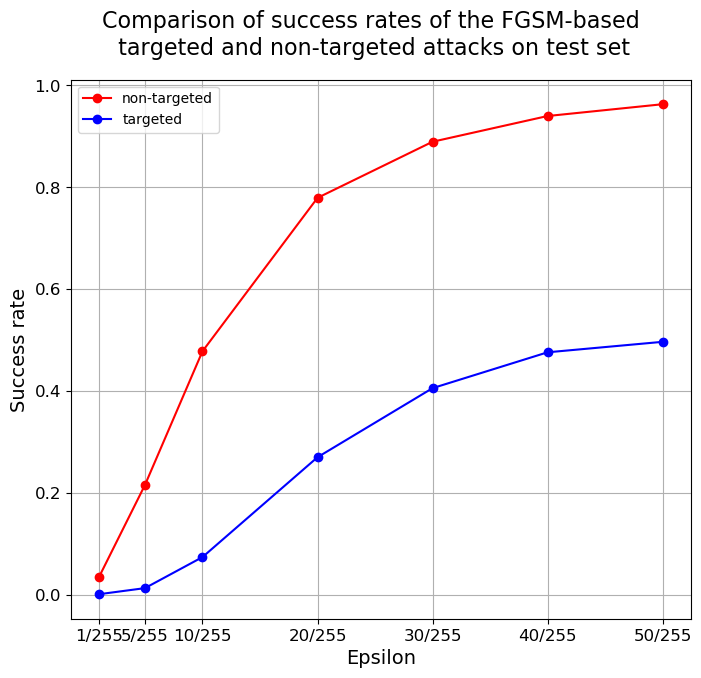

In [19]:
# compare targeted/untargeted attacks
#plot
import matplotlib
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(8,7))
fig.suptitle("Comparison of success rates of the FGSM-based\n targeted and non-targeted attacks on test set",fontsize="16")
ax.set_xticks(epss)
ax.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="12")
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Success rate', fontsize="14")
ax.set_xlabel('Epsilon', fontsize="14")
ax.plot(rptUntargeted['Confuse_frac'], 'ro-', label = 'non-targeted')
ax.plot(rptTargeted['Mislead_frac'], 'bo-',label ='targeted')
ax.grid()
plt.legend();


## Adversarial Retraining against Untargeted FGSM Attacks:

**Q6**: Append the adversarially perturbed images to training set, but using their correct labels.

In [20]:
e = 10/255.0
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
'''
  Your Code
'''
newX = np.vstack((xTrain,FGS_untargeted_attack(xTrain, yTrain, baseModel, loss_func, eps=e)))
newY = np.hstack((yTrain, yTrain))

print(newX.shape)
print(newY.shape)

(120000, 28, 28)
(120000,)


In [21]:
advModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10)
])
advModel.compile(optimizer='adam',
              loss=loss_func,
              metrics=['accuracy'])
advModel.fit(newX, newY, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.3858 - accuracy: 0.8685
Epoch 2/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2562 - accuracy: 0.9110
Epoch 3/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2134 - accuracy: 0.9243
Epoch 4/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1900 - accuracy: 0.9320
Epoch 5/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1727 - accuracy: 0.9378
Epoch 6/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1609 - accuracy: 0.9419
Epoch 7/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1499 - accuracy: 0.9452
Epoch 8/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1413 - accuracy: 0.9483
Epoch 9/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1345 - accuracy: 0.9507
Epoch 10/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.127

**Q7**: Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs. Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack. Is the adversarially retrained DNN robust against adversarial perturbations? 

In [22]:
# evaluate on the test set containing original images:
print("Adversarially retrained DNN loss and accuracy on regular images:", advModel.evaluate(x=xTest, y=yTest, verbose=0))


Adversarially retrained DNN loss and accuracy on regular images: [0.36517202854156494, 0.875]


In [23]:
e=10/255
xTestAftAttack = FGS_untargeted_attack(xTest, yTest, baseModel, loss_func, eps=e)

print("Adversarially retrained DNN loss and accuracy on modified images:", advModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0))

# for i in range(xTest.shape[0]):
#   '''
#     Your Code
#   '''
# costPerPixel = # Your Code

Adversarially retrained DNN loss and accuracy on modified images: [0.0737910345196724, 0.982200026512146]


In [24]:
# the success rate of the attack:
# labels after classifying original images 
yhat = np.argmax(advModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(advModel.predict(xTestAftAttack),axis=1)
#the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
#that are mis-classified after adversarial perturbation

# indices of images correctly classified by the baseline DNN
correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

# number of images correctly classified by the baseline DNN
numCorrectlyClassified = np.sum(yhat==yTest)

# number of images mis-classified after adversarial perturbation
numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

#success rate of attack:
attackSR = numMisclassified/numCorrectlyClassified
print("The success rate of attack with epsilon {:.4f} is {:.4f}".format( e, attackSR))

The success rate of attack with epsilon 0.0392 is 0.0009


In [25]:
# we can check also how the adversarially retrained model performs if the images were generated using the gradients of loss function from adversarially retrained model
xTestAftAttackAdversarial = FGS_untargeted_attack(xTest, yTest, advModel, loss_func, eps=e)

# the success rate of the attack:
# labels after classifying original images 
yhat = np.argmax(advModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(advModel.predict(xTestAftAttackAdversarial),axis=1)
#the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
#that are mis-classified after adversarial perturbation

# indices of images correctly classified by the baseline DNN
correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

# number of images correctly classified by the baseline DNN
numCorrectlyClassified = np.sum(yhat==yTest)

# number of images mis-classified after adversarial perturbation
numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

#success rate of attack:
attackAdversarialSR = numMisclassified/numCorrectlyClassified
print("The success rate of attack with epsilon {:.4f} is {:.4f}".format( e, attackAdversarialSR))

The success rate of attack with epsilon 0.0392 is 0.8273


We can notice that the adversarially retrained DNN is robust against the adversarial perturbations. The success rate of the attack is less than 0.01% for $\epsilon = \frac{10}{255}$.

In [26]:
# adverasial retraining for all epsilon values

epss = np.asarray([1, 5, 10, 20, 30, 40, 50])/255.0
rptAdversarialUntargeted = pd.DataFrame(index=epss, columns=['Confuse_frac_baseline','Accuracy_baseline', 'Confuse_frac_adversarial','Accuracy_adversarial','Confuse_frac_adversarially_retrained','Accuracy_adversarially_retrained'])

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)

for e in epss:
    print("\nCalculating for epsilon = {:.4f}...".format( e))
    
    # generate adversarial images from baseline model:
    xTrainAftAttack = FGS_untargeted_attack(xTrain, yTrain, baseModel, loss_func, eps=e)
    
    newX = np.vstack((xTrain,xTrainAftAttack))
    newY = np.hstack((yTrain, yTrain))
    
    # clear previous session:
    tf.keras.backend.clear_session()
    
    # define adversarial model:
    advModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(10)
    ])
    advModel.compile(optimizer='adam',
                  loss=loss_func,
                  metrics=['accuracy'])

    # train adversarial model:
    advModel.fit(newX, newY, epochs=10, verbose = 0)
    
    # generate adversarial images using test data:
    xTestAftAttack = FGS_untargeted_attack(xTest, yTest, baseModel, loss_func, eps=e)

    # generate adversarial images from adversarially retrained model:
    xTestAftAttackAdversarial = FGS_untargeted_attack(xTest, yTest, advModel, loss_func, eps=e)

    # get the loss and accuracy of the baseline model on the set of adversarial images:
    (lossBaselineModel,accuracyBaselineModel)= baseModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0)
    
    # get the loss and accuracy of the adversarial model on the set of adversarial images generated using baseline model:
    (lossAdvModel,accuracyAdvModel)= advModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0)
    print("Adversarially retrained DNN loss and accuracy on baseline modified images:", (lossAdvModel,accuracyAdvModel))

    # get the loss and accuracy of the adversarial model on the set of adversarial images generated using adversarially retrained model:
    (lossAdvRetrainedModel,accuracyAdvRetrainedModel)= advModel.evaluate(x=xTestAftAttackAdversarial, y=yTest, verbose=0)
    print("Adversarially retrained DNN loss and accuracy on adversarially modified images:", (lossAdvRetrainedModel,accuracyAdvRetrainedModel))


    # the success rate of the attack:
    # labels after classifying original images with baseline model
    yhat = np.argmax(baseModel.predict(xTest),axis=1)
    
    # labels after classifying original images with adversarially retrained model
    yhatAdversarial = np.argmax(baseModel.predict(xTest),axis=1)

    # labels after classifying modified images with baseline model
    yhatPrimeBaseline = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
    
    # labels after classifying baseline modified  images with adversarial model
    yhatPrimeAdversarial = np.argmax(advModel.predict(xTestAftAttack),axis=1)
    
    # labels after classifying adversarially retrained modified images with adversarial model
    yhatPrimeAdversarialRetrained = np.argmax(advModel.predict(xTestAftAttackAdversarial),axis=1)
    

    #the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
    #that are mis-classified after adversarial perturbation

    # indices of images correctly classified by the baseline DNN
    correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]
    correctlyClassifiedAdvIdx= np.where(yhatAdversarial==yTest)[0]

    # number of images correctly classified by the baseline DNN
    numCorrectlyClassified = np.sum(yhat==yTest)
    numCorrectlyClassifiedAdversarial = np.sum(yhatAdversarial==yTest)

    # number of images mis-classified by baseline model after baseline perturbation
    numMisclassifiedBaseline = np.sum(yhatPrimeBaseline[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

    # number of images mis-classified by adversarial model after baseline perturbation
    numMisclassifiedAdversarial = np.sum(yhatPrimeAdversarial[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

    # number of images mis-classified by adversarial model after adversarially retrained perturbation
    numMisclassifiedAdversariallyRetrained = np.sum(yhatPrimeAdversarialRetrained[correctlyClassifiedAdvIdx]!=yTest[correctlyClassifiedAdvIdx])

    #success rate of adversarial attack:
    attackSrBaseline = numMisclassifiedBaseline/numCorrectlyClassified # on a baseline model
    attackSrAdversarial = numMisclassifiedAdversarial/numCorrectlyClassified # on an adversarial model
    attackSrAdversariallyRetrained = numMisclassifiedAdversariallyRetrained/numCorrectlyClassifiedAdversarial # on an adversarially retrained model
    print("\nThe success rate of attack  with epsilon {:.4f} on: \nan adversarial model is {:.4f}\na baseline model is {:.4f}\nan adversarially retrained model is {:.4f}\n".format( e, attackSrAdversarial,attackSrBaseline,attackSrAdversariallyRetrained))
    
    rptAdversarialUntargeted.loc[e, 'Confuse_frac_baseline'] = attackSrBaseline
    rptAdversarialUntargeted.loc[e, 'Accuracy_baseline'] = accuracyBaselineModel
    rptAdversarialUntargeted.loc[e, 'Confuse_frac_adversarial'] = attackSrAdversarial
    rptAdversarialUntargeted.loc[e, 'Accuracy_adversarial'] = accuracyAdvModel
    rptAdversarialUntargeted.loc[e, 'Confuse_frac_adversarially_retrained'] = attackSrAdversariallyRetrained
    rptAdversarialUntargeted.loc[e, 'Accuracy_adversarially_retrained'] = accuracyAdvRetrainedModel
rptAdversarialUntargeted


Calculating for epsilon = 0.0039...
Adversarially retrained DNN loss and accuracy on baseline modified images: (0.26757413148880005, 0.9222000241279602)
Adversarially retrained DNN loss and accuracy on adversarially modified images: (0.9390278458595276, 0.7195000052452087)

The success rate of attack  with epsilon 0.0039 on: 
an adversarial model is 0.0202
a baseline model is 0.0341
an adversarially retrained model is 0.1975


Calculating for epsilon = 0.0196...
Adversarially retrained DNN loss and accuracy on baseline modified images: (0.1195601299405098, 0.9693999886512756)
Adversarially retrained DNN loss and accuracy on adversarially modified images: (4.868747711181641, 0.2930999994277954)

The success rate of attack  with epsilon 0.0196 on: 
an adversarial model is 0.0075
a baseline model is 0.2152
an adversarially retrained model is 0.6689


Calculating for epsilon = 0.0392...
Adversarially retrained DNN loss and accuracy on baseline modified images: (0.07407711446285248, 0.9821

,Confuse_frac_baseline,Accuracy_baseline,Confuse_frac_adversarial,Accuracy_adversarial,Confuse_frac_adversarially_retrained,Accuracy_adversarially_retrained
0.003922,0.0341474,0.8542,0.0202397,0.9222,0.197535,0.7195
0.019608,0.215174,0.6941,0.00746269,0.9694,0.668928,0.2931
0.039216,0.477838,0.4618,0.00463591,0.9821,0.830393,0.15
0.078431,0.779172,0.1953,0.00293985,0.9878,0.940185,0.0529
0.117647,0.889417,0.0978,0.000904568,0.9939,0.936228,0.0568
0.156863,0.939959,0.0531,0.00260063,0.9935,0.947422,0.0473
0.196078,0.963139,0.0326,0.0027137,0.9946,0.837969,0.1522


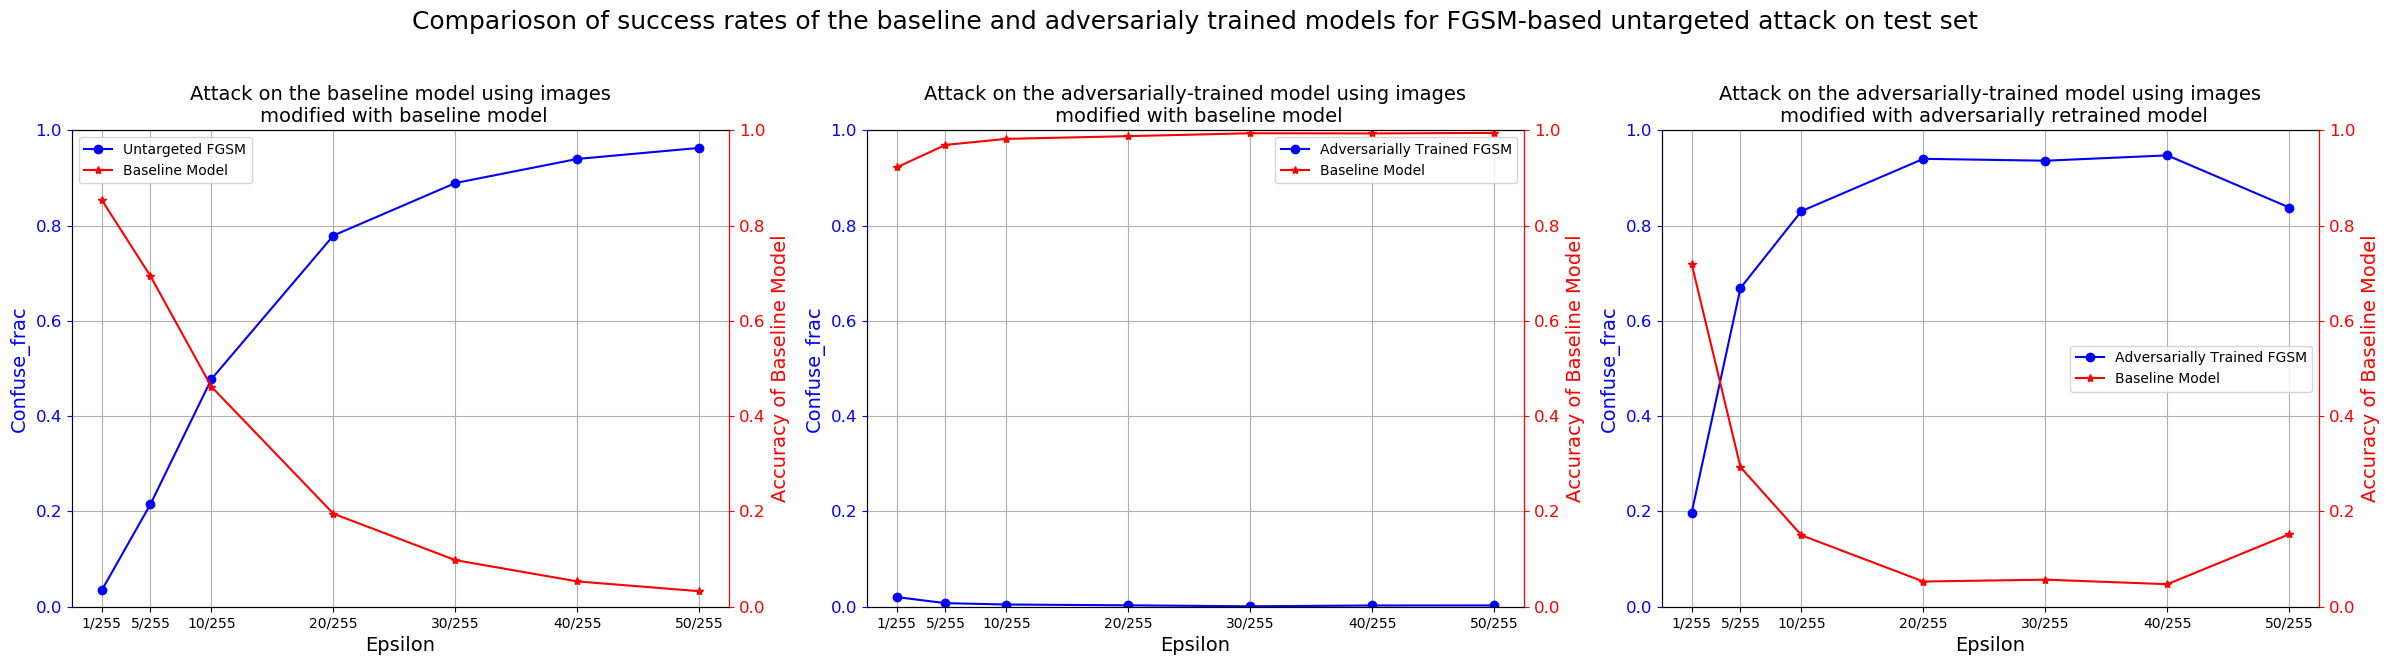

In [27]:
# plot
fig, axes = plt.subplots(1,3,figsize=(24,6))
ax1 = axes[0]
ax2 = ax1.twinx()

ax1.set_xticks(epss)
ax1.set_title("Attack on the baseline model using images\n modified with baseline model",fontsize="14")
ax1.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="10")
ax1.set_xlabel('Epsilon', fontsize="14")
ax1.set_ylabel('Confuse_frac', fontsize="14")
ax1.spines['left'].set_color('blue')
ax1.tick_params(axis='y', colors='blue', labelsize=12)
ax1.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red', labelsize=12)
ax2.yaxis.label.set_color('red')
ax1.plot(epss,  rptAdversarialUntargeted['Confuse_frac_baseline'], 'bo-',label = "Untargeted FGSM")
ax1.plot(epss, rptAdversarialUntargeted['Accuracy_baseline'], 'r*-',label = "Baseline Model")
ax1.set_ylim([0,1])
ax1.grid()
ax1.legend();

ax1 = axes[1]
ax2 = ax1.twinx()
ax1.set_title("Attack on the adversarially-trained model using images\n modified with baseline model",fontsize="14")
ax1.set_xticks(epss)
ax1.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="10")
ax1.set_xlabel('Epsilon', fontsize="14")
ax1.set_ylabel('Confuse_frac', fontsize="14")
ax1.spines['left'].set_color('blue')
ax1.tick_params(axis='y', colors='blue', labelsize=12)
ax1.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red', labelsize=12)
ax2.yaxis.label.set_color('red')
ax1.plot(epss,  rptAdversarialUntargeted['Confuse_frac_adversarial'], 'bo-',label = "Adversarially Trained FGSM")
ax1.plot(epss, rptAdversarialUntargeted['Accuracy_adversarial'], 'r*-',label = "Baseline Model")
ax1.set_ylim([0,1])
ax1.grid()
ax1.legend();

ax1 = axes[2]
ax2 = ax1.twinx()
ax1.set_title("Attack on the adversarially-trained model using images\n modified with adversarially retrained model",fontsize="14")
ax1.set_xticks(epss)
ax1.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="10")
ax1.set_xlabel('Epsilon', fontsize="14")
ax1.set_ylabel('Confuse_frac', fontsize="14")
ax1.spines['left'].set_color('blue')
ax1.tick_params(axis='y', colors='blue', labelsize=12)
ax1.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red', labelsize=12)
ax2.yaxis.label.set_color('red')
ax1.plot(epss,  rptAdversarialUntargeted['Confuse_frac_adversarially_retrained'], 'bo-',label = "Adversarially Trained FGSM")
ax1.plot(epss, rptAdversarialUntargeted['Accuracy_adversarially_retrained'], 'r*-',label = "Baseline Model")
ax1.set_ylim([0,1])
ax1.grid()
ax1.legend();

fig.tight_layout()
fig.suptitle("Comparison of success rates of the baseline and adversarialy trained models for FGSM-based untargeted attack on test set",fontsize="18", y=1.1);

We can notice that the adversarially-retrained DNN is robust against adversarial perturbations for any $\epsilon$ values (second figure). The accuracy of the adversarially-retrained DNN increases with $\epsilon$ which might be due to the overfitting for smaller $\epsilon$ values, when the attacks success rates are usually very low and generated images are almost undistinguishable from the originals. However, when the perturbations become significantly noticeable for larger $\epsilon$ the network differentiates between perturbed and original images more clearly.

However, the adversarially retrained network is not robust if we attack it with images, generated using the gradients of loss function from adversarially retrained model (third figure). The success rate reaches almost 98% for $\epsilon = \frac{30}{255}$.

# Adversarial attack challenge

## PGD
In Projected Gradient Descent (PGD) a cost function is minimized subject to some constraint over many iterations. Any time we get a result that does not satisfy the constraint, i.e. falls down outside of the "physical space."  In PGD when we exceed the constraints we project the value back to the feasible region, i.e. to the point in the feasible region closest the newly-obtained point.

Projected Gradient Descent (PGD) for an untargeted attack can be expressed as:

$x_0' = x$

$x_{N+1}' \leftarrow \text{project}_{\epsilon}\left(x_{N}'+\alpha\text{sign}\left(\nabla l_{F,y^*}(x)\right)\right)$

where $x_{N}'$ -- modified image on $N$-th iteration, $x_{N+1}'$ -- on $N+1$-st, $\epsilon$ is a small constraint value that defines the feasible region, $\alpha$-- step, usually $\alpha = \frac{\epsilon}{N_{iter}}$, $N_{iter}$ -- number of iterations, $l$ is the lost function and $\text{project}_{\epsilon}()$ function projects the value back to the feasible region. 

In our case there is an additional constraint that the Root Mean Square Error (RMSE) averaged over all the images in the the original and modified datasets is less than  $5/255$. 

In [28]:
def PGD_untargeted_attack(X, label, model, loss_func, numIterations, eps=1,C = 5/255, alpha=1, verbose = 1):    
    newX = X.copy()
    meanRmse = 0
    for iteration in range(numIterations):
        X_tensor = tf.convert_to_tensor(newX, dtype=tf.float32)
        oldX = newX
        with tf.GradientTape() as g:
            g.watch(X_tensor)
            lossTensor = loss_func(label, model(X_tensor))

        # calculate gradients of loss function:
        lossGradientsTensor = g.gradient(lossTensor, X_tensor)
        
        if verbose:
                print("iteration: {:3d}, RMSE: {:.4f}, constraint: RMSE<{:.4f}".format(iteration, meanRmse, C))
        newX = newX + alpha*np.sign(lossGradientsTensor)
        newX = np.clip(newX, X-eps, X+eps)
            
        rmseArray = np.zeros((X.shape[0]))
        # recalculate constraints
        for i in range(X.shape[0]):
            img0 = X[i].flatten()
            img1 = np.clip(newX[i],0,1).flatten()
            rmseArray[i] = np.sqrt(((img0 - img1) ** 2).mean())

        meanRmse = np.mean(rmseArray)

        if meanRmse >= C:
            if verbose:
                print("iteration: {:3d}, RMSE: {:.4f} is greater than {:.4f}, breaking...".format(iteration,meanRmse,C))
            newX=oldX # do not change anything
            break
    return newX

In [ ]:
# selecting best epsilon/alpha
epss = np.asarray([1, 5, 10, 20, 30, 40, 50])/255.0
alphas = np.asarray([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0, 1.5, 2])/255.0
numIterations = 500
C = 5/255

attackSrTotal = np.zeros((epss.shape[0],alphas.shape[0]))
accuracyTotal = np.zeros((epss.shape[0],alphas.shape[0]))

for i1, e in enumerate(epss):
    for i2, alpha in enumerate(alphas):
        
        # generate adversarial images
        xTestAftAttack = PGD_untargeted_attack(xTest, yTest, baseModel, loss_func, numIterations, eps=e, alpha=alpha, C=C,verbose = 0)

        # labels after classifying original images 
        yhat = np.argmax(baseModel.predict(xTest),axis=1)
        # labels after classifying modified images
        yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
        #the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
        #that are mis-classified after adversarial perturbation

        # indices of images correctly classified by the baseline DNN
        correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

        # number of images correctly classified by the baseline DNN
        numCorrectlyClassified = np.sum(yhat==yTest)

        # number of images mis-classified after adversarial perturbation
        numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

        #success rate of attack:
        attackSR = numMisclassified/numCorrectlyClassified
        accuracy = np.sum(yhatPrime==yTest)/yTest.shape
        
        attackSrTotal[i1,i2]=attackSR
        accuracyTotal[i1,i2]=accuracy
        print("The success rate of attack with epsilon {:.4f} and alpha {:.4f} is {:.4f}".format(e, alpha, attackSR))

The success rate of attack with epsilon 0.0039 and alpha 0.0002 is 0.0477
The success rate of attack with epsilon 0.0039 and alpha 0.0004 is 0.0477
The success rate of attack with epsilon 0.0039 and alpha 0.0006 is 0.0477


In [ ]:
# parameter selection based on success rate of the attack
ind = np.unravel_index(np.argmax(attackSrTotal.T, axis=None), attackSrTotal.T.shape)

alphasStr = ['0.05/255', '0.1/255', '0.15/255', '0.2/255', '0.25/255', '0.3/255', '0.35/255', '0.4/255', '0.45/255', '0.5/255', '0.6/255', '0.8/255', '1.0/255', '1.5/255', '2/255']
epsilonStr  = ['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255']                
plt.figure(figsize=(10, 7))
df_rec = pd.DataFrame(attackSrTotal.T, index=alphas, columns=epss)
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_rec, cbar_kws={'ticks': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, vmin=0.2, vmax=1.0, annot=True,
                 annot_kws={"size": 8}, fmt='.3f', cmap="Reds")  # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0, 1.5, 2
ax.set_yticklabels(alphasStr,rotation=0, fontsize="16", va="center")
ax.set_xticklabels(epsilonStr,rotation=0, fontsize="16", va="center")
im1 = ax.imshow(attackSrTotal.T, aspect='auto', cmap='Reds')
ax.invert_yaxis()
ax.set_title('Success rates ot the PGD non-targeted attack')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Alpha');
matplotlib.rc_file_defaults()
print(ind)
#
print('optimal parameters are: \nalpha = %s, epsilon = %s\n' %( alphasStr[ind[0]],epsilonStr[ind[1]]))


In [ ]:
numIterations = 500
e = 10/255
C = 5/255
alpha = 0.05/255

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
xTestAftAttack = PGD_untargeted_attack(xTest, yTest, baseModel, loss_func, numIterations, eps=e, alpha=alpha, C=C,verbose = 1)

rmseArray = np.zeros((xTest.shape[0]))
# recalculate constraints
for i in range(xTest.shape[0]):
    img0 = xTest[i].flatten()
    img1 = xTestAftAttack[i].flatten()
    rmseArray[i] = np.sqrt(((img0 - img1) ** 2).mean())

meanRmse = np.mean(rmseArray)
print("RMSE = {:.4f}  C = {:.4f}".format(meanRmse,C))

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)


# plot randomly selected modified and original images side-by-side
from mpl_toolkits.axes_grid1 import make_axes_locatable

num = 10
# set some specific seed
np.random.seed(45)
# define the random index of the image which we will be using all the time here
randIdx = [np.random.randint(10000) for i in range(num)]
idx = -1

fig, axes = plt.subplots(1, 2, figsize=(12,12))
divider1 = make_axes_locatable(axes[0])
divider2 = make_axes_locatable(axes[1])
im1  =  axes[0].imshow(xTest[randIdx[idx]])
im2  =  axes[1].imshow(xTestAftAttack[randIdx[idx]])
axes[0].set_title('Original image, orig. label: {}, pred. label: {}'.format(yTest[randIdx[idx]], yhat[randIdx[idx]]))
axes[1].set_title('Modified image, orig. label: {}, pred. label: {}, epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrime[randIdx[idx]], e))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
im1.set_clim(0, 1)
im2.set_clim(0, 1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
plt.tight_layout()
plt.show()


In [ ]:
# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
#the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
#that are mis-classified after adversarial perturbation

# indices of images correctly classified by the baseline DNN
correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

# number of images correctly classified by the baseline DNN
numCorrectlyClassified = np.sum(yhat==yTest)

# number of images mis-classified after adversarial perturbation
numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

#success rate of attack:
attackSR = numMisclassified/numCorrectlyClassified
print("The success rate of attack with epsilon {:.4f} is {:.4f}".format(e, attackSR))


In [ ]:
# plotting some of the images adversarially perturbed with PGD 
# plot
num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3.5*num_col,3.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    im = ax.imshow(xTestAftAttack[randIdx[i]])
    ax.set_title('original label: {}, predicted label: {}\n epsilon: {:.4f}'.format(yTest[randIdx[i]],yhatPrime[randIdx[i]], e))
    ax.set_xticks([])
    ax.set_yticks([])
    divider= make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im.set_clim(0, 1)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show();

In [ ]:

attackSr = attackSrTotal.T[ind[0],:]
atttackAcc = accuracyTotal.T[ind[0],:]

fig, ax = plt.subplots(figsize=(10,7))
ax2 = ax.twinx()
plt.title("Success rate of the PGD-based non-targeted attack on test set for alpha = "+alphasStr[ind[0]],fontsize="14")
ax.set_xticks(epss)
ax.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="12")
ax.set_ylabel('Confuse_frac', fontsize="14")
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue', labelsize=12)
ax.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax.set_xlabel('Epsilon', fontsize="14")
ax.plot(epss, attackSr, 'bo-',label = "Untargeted PGD")
ax.plot(epss, atttackAcc, 'r*-',label = "Baseline Accuracy")
ax.set_ylim([0,1])
ax.grid()
ax.legend();


##  IFGSM

Iterative Fast Gradient Sign Method for an untargeted attack can be expressed as:

$x_0' = x$

$x_{N+1}' \leftarrow \text{clip}_{\epsilon}\left(x_{N}'+\alpha\text{sign}\left(\nabla l_{F,y^*}(x)\right)\right)$

where $x_{N}'$ -- modified image on $N$-th iteration, $x_{N+1}'$ -- on $N+1$-st, $\epsilon$ is a small constraint value, $\alpha$-- step, usually $\alpha = \frac{\epsilon}{N_{iter}}$, $N_{iter}$ -- number of iterations, $l$ is the lost function and $\text{clip}_{\epsilon}()$ function brings all the pixels of the image to the same range, e.g. from 0 to 255.


In [ ]:
from numpy import linalg as LA
def IFGSM_untargeted_attack(X, label, model, loss_func, numIterations, eps=1,C = 5/255, alpha=1, verbose = 1):
    newX = X.copy()
    meanRmse = 0
    for iteration in range(numIterations):
        X_tensor = tf.convert_to_tensor(newX, dtype=tf.float32)
        oldX = newX
        with tf.GradientTape() as g:
            g.watch(X_tensor)
            lossTestTensor = loss_func(label, model(X_tensor))

        # calculate gradients of loss function:   
        lossGradientsTensor = g.gradient(lossTestTensor, X_tensor)

        if verbose:
            print("iteration: {:3d}, RMSE: {:.4f}, constraint: RMSE<{:.4f}".format(iteration, meanRmse, C))
        newX = np.clip(newX+alpha*np.sign(lossGradientsTensor), 0.0, 1.0)
        norm = LA.norm((X.copy()-newX).ravel(), ord= np.inf)
        if norm > eps:
            if verbose:
                print("iteration: {:3d}, delta: {:.4f} is greater than epsilon: {:.4f}, breaking...".format(iteration,norm,eps))
            break
        
        rmseArray = np.zeros((X.shape[0]))
        # recalculate constraints
        for i in range(X.shape[0]):
            img0 = X[i].flatten()
            img1 = newX[i].flatten()
            rmseArray[i] = np.sqrt(((img0 - img1) ** 2).mean())

        meanRmse = np.mean(rmseArray)

        if meanRmse >= C:
            if verbose:
                print("iteration: {:3d}, RMSE: {:.4f} is greater than {:.4f}, breaking...".format(iteration,meanRmse,C))
            newX=oldX # do not change anything
            break
    return newX

In [ ]:
# selecting best epsilon/alpha
epss = np.asarray([1, 5, 10, 20, 30, 40, 50])/255.0
alphas = np.asarray([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0, 1.5, 2])/255.0
numIterations = 500
C = 5/255

attackSrTotalIFGSM = np.zeros((epss.shape[0],alphas.shape[0]))
accuracyTotalIFGSM = np.zeros((epss.shape[0],alphas.shape[0]))

for i1, e in enumerate(epss):
    for i2, alpha in enumerate(alphas):
        
        # generate adversarial images
        xTestAftAttack = IFGSM_untargeted_attack(xTest, yTest, baseModel, loss_func, numIterations, eps=e, alpha=alpha, C=C,verbose = 0)

        # labels after classifying original images 
        yhat = np.argmax(baseModel.predict(xTest),axis=1)
        # labels after classifying modified images
        yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
        #the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
        #that are mis-classified after adversarial perturbation

        # indices of images correctly classified by the baseline DNN
        correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

        # number of images correctly classified by the baseline DNN
        numCorrectlyClassified = np.sum(yhat==yTest)

        # number of images mis-classified after adversarial perturbation
        numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

        #success rate of attack:
        attackSR = numMisclassified/numCorrectlyClassified
        accuracy = np.sum(yhatPrime==yTest)/yTest.shape
        
        attackSrTotalIFGSM[i1,i2]=attackSR
        accuracyTotalIFGSM[i1,i2]=accuracy
        print("The success rate of attack with epsilon {:.4f} and alpha {:.4f} is {:.4f}".format(e, alpha, attackSR))

In [ ]:
# parameter selection based on success rate of the attack
ind = np.unravel_index(np.argmax(attackSrTotalIFGSM.T, axis=None), attackSrTotalIFGSM.T.shape)

alphasStr = ['0.05/255', '0.1/255', '0.15/255', '0.2/255', '0.25/255', '0.3/255', '0.35/255', '0.4/255', '0.45/255', '0.5/255', '0.6/255', '0.8/255', '1.0/255', '1.5/255', '2/255']
epsilonStr  = ['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255']                
plt.figure(figsize=(10, 7))
df_rec = pd.DataFrame(attackSrTotalIFGSM.T, index=alphas, columns=epss)
sns.set(font_scale=1.4)  # for label size
ax = sns.heatmap(df_rec, cbar_kws={'ticks': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, vmin=0.2, vmax=1.0, annot=True,
                 annot_kws={"size": 8}, fmt='.3f', cmap="Reds")  # font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0, 1.5, 2
ax.set_yticklabels(alphasStr,rotation=0, fontsize="16", va="center")
ax.set_xticklabels(epsilonStr,rotation=0, fontsize="16", va="center")
im1 = ax.imshow(attackSrTotalIFGSM.T, aspect='auto', cmap='Reds')
ax.invert_yaxis()
ax.set_title('Success rates ot the IFGSM non-targeted attack')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Alpha');
matplotlib.rc_file_defaults()
print(ind)
#
print('optimal parameters are: \nalpha = %s, epsilon = %s\n' %( alphasStr[ind[0]],epsilonStr[ind[1]]))


In [ ]:
numIterations = 500
e = 10/255
C = 5/255
alpha = 0.1/255

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
xTestAftAttack = IFGSM_untargeted_attack(xTest, yTest, baseModel, loss_func, numIterations, eps=e, alpha=alpha, C=C,verbose = 1)

rmseArray = np.zeros((xTest.shape[0]))
# recalculate constraints
for i in range(xTest.shape[0]):
    img0 = xTest[i].flatten()
    img1 = xTestAftAttack[i].flatten()
    rmseArray[i] = np.sqrt(((img0 - img1) ** 2).mean())

meanRmse = np.mean(rmseArray)
print("RMSE = {:.4f}  C = {:.4f}".format(meanRmse,C))

# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)


# plot randomly selected modified and original images side-by-side
from mpl_toolkits.axes_grid1 import make_axes_locatable

num = 10
# set some specific seed
np.random.seed(45)
# define the random index of the image which we will be using all the time here
randIdx = [np.random.randint(10000) for i in range(num)]
idx = -1

fig, axes = plt.subplots(1, 2, figsize=(12,12))
divider1 = make_axes_locatable(axes[0])
divider2 = make_axes_locatable(axes[1])
im1  =  axes[0].imshow(xTest[randIdx[idx]])
im2  =  axes[1].imshow(xTestAftAttack[randIdx[idx]])
axes[0].set_title('Original image, orig. label: {}, pred. label: {}'.format(yTest[randIdx[idx]], yhat[randIdx[idx]]))
axes[1].set_title('Modified image, orig. label: {}, pred. label: {}, epsilon: {:.4f}'.format(yTest[randIdx[idx]],yhatPrime[randIdx[idx]], e))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
im1.set_clim(0, 1)
im2.set_clim(0, 1)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
plt.tight_layout()
plt.show()


In [ ]:
# labels after classifying original images 
yhat = np.argmax(baseModel.predict(xTest),axis=1)
# labels after classifying modified images
yhatPrime = np.argmax(baseModel.predict(xTestAftAttack),axis=1)
#the success rate of attack is the fraction of test images that were correctly classified by the baseline DNN 
#that are mis-classified after adversarial perturbation

# indices of images correctly classified by the baseline DNN
correctlyClassifiedBaselineIdx = np.where(yhat==yTest)[0]

# number of images correctly classified by the baseline DNN
numCorrectlyClassified = np.sum(yhat==yTest)

# number of images mis-classified after adversarial perturbation
numMisclassified = np.sum(yhatPrime[correctlyClassifiedBaselineIdx]!=yTest[correctlyClassifiedBaselineIdx])

#success rate of attack:
attackSR = numMisclassified/numCorrectlyClassified
print("The success rate of attack with epsilon {:.4f} is {:.4f}".format(e, attackSR))


In [ ]:
# plotting some of the images adversarially perturbed with IFGSM 
# plot
num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3.5*num_col,3.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    im = ax.imshow(xTestAftAttack[randIdx[i]])
    ax.set_title('original label: {}, predicted label: {}\n epsilon: {:.4f}'.format(yTest[randIdx[i]],yhatPrime[randIdx[i]], e))
    ax.set_xticks([])
    ax.set_yticks([])
    divider= make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im.set_clim(0, 1)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show();

In [ ]:

attackSr = attackSrTotalIFGSM.T[ind[0],:]
atttackAcc = accuracyTotalIFGSM.T[ind[0],:]

fig, ax = plt.subplots(figsize=(10,7))
ax2 = ax.twinx()
plt.title("Success rate of the IFGSM-based non-targeted attack on test set for alpha = "+alphasStr[ind[0]],fontsize="14")
ax.set_xticks(epss)
ax.set_xticklabels(['1/255', '5/255', '10/255', '20/255', '30/255', '40/255', '50/255'],fontsize="12")
ax.set_ylabel('Confuse_frac', fontsize="14")
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue', labelsize=12)
ax.yaxis.label.set_color('blue')
ax2.set_ylabel('Accuracy of Baseline Model', fontsize="14")
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax.set_xlabel('Epsilon', fontsize="14")
ax.plot(epss, attackSr, 'bo-',label = "Untargeted PGD")
ax.plot(epss, atttackAcc, 'r*-',label = "Baseline Accuracy")
ax.set_ylim([0,1])
ax.grid()
ax.legend();
